<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-Channel-wide-Podcast-Play-Count" data-toc-modified-id="Predicting-Channel-wide-Podcast-Play-Count-1">Predicting Channel-wide Podcast Play Count</a></span><ul class="toc-item"><li><span><a href="#Notebook-Overview:" data-toc-modified-id="Notebook-Overview:-1.1">Notebook Overview:</a></span></li></ul></li><li><span><a href="#Load-Raw-Scraped-Data" data-toc-modified-id="Load-Raw-Scraped-Data-2">Load Raw Scraped Data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Drop-Empties-/-NaN-rows-before-feature-development" data-toc-modified-id="Drop-Empties-/-NaN-rows-before-feature-development-2.0.1">Drop Empties / NaN rows before feature development</a></span></li></ul></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3">Feature Engineering</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Utilities:" data-toc-modified-id="Utilities:-3.0.1">Utilities:</a></span><ul class="toc-item"><li><span><a href="#Outlier-Filter" data-toc-modified-id="Outlier-Filter-3.0.1.1">Outlier Filter</a></span></li></ul></li></ul></li><li><span><a href="#Enrich-Existing-Column-Catogory" data-toc-modified-id="Enrich-Existing-Column-Catogory-3.1">Enrich Existing Column Catogory</a></span><ul class="toc-item"><li><span><a href="#One-Hot-Encoding" data-toc-modified-id="One-Hot-Encoding-3.1.1">One-Hot Encoding</a></span></li></ul></li><li><span><a href="#Social-Channels" data-toc-modified-id="Social-Channels-3.2">Social Channels</a></span><ul class="toc-item"><li><span><a href="#Create-Categorical-Columns-Representing-Social-Site-Presence" data-toc-modified-id="Create-Categorical-Columns-Representing-Social-Site-Presence-3.2.1">Create Categorical Columns Representing Social Site Presence</a></span></li><li><span><a href="#Pull-in-Twitter-Follower-Counts" data-toc-modified-id="Pull-in-Twitter-Follower-Counts-3.2.2">Pull in Twitter Follower Counts</a></span></li></ul></li><li><span><a href="#External-Site-Domain-Rank" data-toc-modified-id="External-Site-Domain-Rank-3.3">External Site Domain Rank</a></span><ul class="toc-item"><li><span><a href="#Identify-Non-Social-External-Site,-and-Return/Append-Domain-Rank-Information" data-toc-modified-id="Identify-Non-Social-External-Site,-and-Return/Append-Domain-Rank-Information-3.3.1">Identify Non-Social External Site, and Return/Append Domain Rank Information</a></span></li></ul></li><li><span><a href="#Add-Episode-Time-Series-Features" data-toc-modified-id="Add-Episode-Time-Series-Features-3.4">Add Episode Time Series Features</a></span></li><li><span><a href="#Distribution-of-Target-Variable" data-toc-modified-id="Distribution-of-Target-Variable-3.5">Distribution of Target Variable</a></span><ul class="toc-item"><li><span><a href="#Target-Variable-=-play_count" data-toc-modified-id="Target-Variable-=-play_count-3.5.1">Target Variable = <code>play_count</code></a></span></li></ul></li><li><span><a href="#Text-Based-Analysis" data-toc-modified-id="Text-Based-Analysis-3.6">Text Based Analysis</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-4">Models</a></span><ul class="toc-item"><li><span><a href="#Testing-simple-linear-models:" data-toc-modified-id="Testing-simple-linear-models:-4.1">Testing simple linear models:</a></span><ul class="toc-item"><li><span><a href="#Minimal-Features---No-Categoricals" data-toc-modified-id="Minimal-Features---No-Categoricals-4.1.1">Minimal Features - No Categoricals</a></span></li></ul></li></ul></li></ul></div>

In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import pickle
import features
import copy

# from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from importlib import reload

import re
import string

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

In [3]:
reload(features)

<module 'features' from '/Users/tk/Google Drive (thomaskavanagh.dev@gmail.com)/GitHub/regression-podcast-popularity/notebooks/features.py'>

# Predicting Channel-wide Podcast Play Count

For this __regression__ modeling project, I've examined podcast channels, their 'store-front' / public-facing channel features, in order to predict play count.

The intended business impact of this study is to identify the most impactful features on total episode play count, such as podcasts store-front, social presence, episode regularity / length. This model is intended for use by both podcast advertisers and producers alike, both of whom seek to gain from total impressions on a podcast.

I've gathered a list of podcasts, and the associated target metric of `play_count` representing total plays across all episodes. I used the site [CastBox.fm] as a directory of podcasts, first scraping a list top podcasts in each category, then scraping all channels from those category directories.

Some podcasts were in the top 200 of multiple categories.

From each channel page, I accumulated the following information:

`
'title', # Podcast name
'chan_url', # Channel page on Castbox.fm
'num_comments', # Total comments on channel page sidebar (specific to Castbox)
'author', # Channel author
'isExplicit', # Explicit content tag (exists if ANY podcast is explicit)
'sub_count', # Subscriber count
'play_count', # Total channel plays
'ch_feed_socials', # A list of all associated social/external URLs listed on their channel page 
'ep_total', # Total episode count
'recent_eps', # A list of recent episodes, as lists of [ep_date, ep_time, number_of_favorites]
'hover_text_concat', # The 'hover text', concatenated with pipes, of the last 7 episodes (if they exist)
'chan_desc', # The channel description
'cover_img_url', # The cover image URL
'first_release', # The date of the first episode release
'scraped_category', # The original category from which it was scraped
`

I've enriched this scraped dataset with the following outside sources:

- Twitter Data. If a podcast channel lists a twitter, I used the API to return follower count.
- Open Page Rank. If a podcast lists an external domain, I computed the rank of that domain using the  [Open Page Rank](https://www.domcop.com/openpagerank/) API.

Gathered data is timestamped to the October 5-10th, 2019 period, when both the channels and social metrics were scraped.

## Notebook Overview:

- Load raw data

- Enrich data with outside datasets.
 - Append additional category qualifications to the original 'scraped' category. The original scrape only logged each podcast as living under a single category, when according to Castbox.fb
 - If an external site is listed on a channel, get it's relative domain quality, as ranked by Open Page Rank.
 - If a twitter username is provided for a channel, get it's follower count.

# Load Raw Scraped Data

Take latest version of dataframe from `/merged/`

In [4]:
df_version = 'merged_10-08_13-54.pickle'
import_path = '../scraped/merged/' + df_version
with open(import_path, 'rb') as file:
    df = pickle.load(file)
    
df.rename(columns={'ch_feed-socials': 'ch_feed_socials', 'category':'scraped_category'}, inplace=True) # fix badly named column
    
print('shape of raw df: ', df.shape)
print('number of empty columns: ', df[df.ep_total == 0].shape)
df.columns

shape of raw df:  (7777, 15)
number of empty columns:  (119, 15)


Index(['title', 'chan_url', 'num_comments', 'author', 'isExplicit',
       'sub_count', 'play_count', 'ch_feed_socials', 'ep_total', 'recent_eps',
       'hover_text_concat', 'chan_desc', 'cover_img_url', 'first_release',
       'scraped_category'],
      dtype='object')

In [5]:
df.head(1)

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed_socials,ep_total,recent_eps,hover_text_concat,chan_desc,cover_img_url,first_release,scraped_category
0,At The Table with Patrick Lencioni,https://castbox.fm/channel/At-The-Table-with-P...,0,Patrick Lencioni,0,119,1686,[https://www.tablegroup.com],13,"[[2019-10-02, 00:34:32, 0], [2019-09-25, 00:27...",Without understanding how people are wired it ...,Real conversations and practical advice for ev...,https://is3-ssl.mzstatic.com/image/thumb/Podca...,2019-07-11,Management


### Drop Empties / NaN rows before feature development

Some channels are missing data, or have no episodes. Remove them.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 59
Data columns (total 15 columns):
title                7777 non-null object
chan_url             7777 non-null object
num_comments         7777 non-null int64
author               7777 non-null object
isExplicit           7777 non-null int64
sub_count            7777 non-null int64
play_count           7777 non-null int64
ch_feed_socials      7777 non-null object
ep_total             7777 non-null int64
recent_eps           7759 non-null object
hover_text_concat    7759 non-null object
chan_desc            7759 non-null object
cover_img_url        7759 non-null object
first_release        7777 non-null object
scraped_category     7777 non-null object
dtypes: int64(5), object(10)
memory usage: 972.1+ KB


In [7]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7759 entries, 0 to 59
Data columns (total 15 columns):
title                7759 non-null object
chan_url             7759 non-null object
num_comments         7759 non-null int64
author               7759 non-null object
isExplicit           7759 non-null int64
sub_count            7759 non-null int64
play_count           7759 non-null int64
ch_feed_socials      7759 non-null object
ep_total             7759 non-null int64
recent_eps           7759 non-null object
hover_text_concat    7759 non-null object
chan_desc            7759 non-null object
cover_img_url        7759 non-null object
first_release        7759 non-null object
scraped_category     7759 non-null object
dtypes: int64(5), object(10)
memory usage: 969.9+ KB


We should remove any rows with 0 episodes.

In [8]:
df[df.ep_total == 0].sort_values('recent_eps',ascending=False)[['ep_total', 'recent_eps']]

,ep_total,recent_eps
47,0,"[[2019-10-02, 00:54:20, 4], [2019-09-25, 00:57..."
45,0,"[[2019-09-24, 00:45:52, 0], [2019-09-10, 00:47..."
46,0,"[[2019-09-24, 00:21:38, 2], [2019-09-17, 00:26..."
48,0,[]
87,0,[]
...,...,...
58,0,[]
56,0,[]
52,0,[]
44,0,[]


In [9]:
# for EDA, mask entries where no episodes have been logged
df = df[df['ep_total'] != 0]

In [10]:
df.shape

(7658, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7658 entries, 0 to 59
Data columns (total 15 columns):
title                7658 non-null object
chan_url             7658 non-null object
num_comments         7658 non-null int64
author               7658 non-null object
isExplicit           7658 non-null int64
sub_count            7658 non-null int64
play_count           7658 non-null int64
ch_feed_socials      7658 non-null object
ep_total             7658 non-null int64
recent_eps           7658 non-null object
hover_text_concat    7658 non-null object
chan_desc            7658 non-null object
cover_img_url        7658 non-null object
first_release        7658 non-null object
scraped_category     7658 non-null object
dtypes: int64(5), object(10)
memory usage: 957.2+ KB


In [12]:
df.dtypes

title                object
chan_url             object
num_comments          int64
author               object
isExplicit            int64
sub_count             int64
play_count            int64
ch_feed_socials      object
ep_total              int64
recent_eps           object
hover_text_concat    object
chan_desc            object
cover_img_url        object
first_release        object
scraped_category     object
dtype: object

# Feature Engineering

### Utilities:

#### Outlier Filter

In [13]:
pd.set_option('display.max_colwidth', 100)
# podcasts with over 10 million plays
df[df.play_count > 10000000.0].sort_values('play_count', ascending=False).head(2)

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed_socials,ep_total,recent_eps,hover_text_concat,chan_desc,cover_img_url,first_release,scraped_category
0,The Joe Rogan Experience,https://castbox.fm/channel/The-Joe-Rogan-Experience-id1608,21769,Joe Rogan,1,2262375,76019418,"[https://twitter.com/joerogan, https://www.facebook.com/JOEROGAN, https://www.instagram.com/joer...",1511,"[[2019-10-03, 02:49:11, 55], [2019-10-02, 02:15:06, 87], [2019-10-02, 02:52:14, 190], [2019-10-0...","Nikki Glaser is a stand-up comedian, podcast host, and television host. Her new stand-up special...",The podcast of Comedian Joe Rogan..,https://is5-ssl.mzstatic.com/image/thumb/Podcasts123/v4/12/ab/d6/12abd655-2473-c4fb-7d53-33e1b9e...,2009-12-24,Comedy
2,TED Talks Daily,https://castbox.fm/channel/TED-Talks-Daily-id4541,712,TED,0,1385328,27994918,"[https://twitter.com/TEDTalks, https://www.facebook.com/TED, https://www.instagram.com/ted, http...",977,"[[2019-10-07, 00:09:30, 8], [2019-10-05, 00:18:50, 15], [2019-10-04, 00:17:02, 15], [2019-10-03,...",Exactly when and where did life on Earth begin? Scientists have long thought that it emerged thr...,"Want TED Talks on the go? Every weekday, this feed brings you our latest talks in audio format. ...",https://is1-ssl.mzstatic.com/image/thumb/Podcasts113/v4/79/9c/44/799c444a-ce56-3e2b-7dc8-a539925...,2016-02-08,Arts


In [78]:
# filter for outliers in play_count
# rule is > 3 std from the mean play_count

pc_mean = df.play_count.mean()
pc_sd = df.play_count.std()

outlier_mask = np.abs(np.subtract(df.play_count, pc_mean)) < 3*pc_sd

In [79]:
# Test play_count outlier mask
df[outlier_mask].describe()

,num_comments,isExplicit,sub_count,play_count,ep_total,cat_count,d_After_Shows,d_Alternative_Health,d_Animation_Manga,d_Arts,...,twitter_sqrt,twitter_log,page_rank_dec,rank,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,avg_ep_desc_len,chan_desc_len
count,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,...,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0,7502.0
mean,10.5,0.2,4423.3,72891.5,136.1,1.2,0.0,0.0,0.0,0.0,...,38.4,-inf,4.4,19530903.9,15.9,0.2,217.7,935.9,766.1,389.5
std,52.0,0.4,19104.4,268631.6,273.7,0.8,0.0,0.2,0.1,0.2,...,241.5,nan,2.1,50788167.3,29.9,1.1,1.4,1190.7,1555.4,318.5
min,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-inf,0.0,2.0,0.0,0.0,211.7,0.0,1.0,0.0
25%,0.0,0.0,35.0,309.2,19.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-inf,3.2,17145.8,6.2,0.1,216.8,198.2,269.5,187.0
50%,0.0,0.0,254.0,3430.0,61.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-inf,4.5,570573.0,7.7,0.1,217.7,613.5,464.4,322.0
75%,3.0,0.0,1543.2,25771.0,157.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-inf,6.0,7668442.0,15.6,0.2,218.6,1315.0,866.2,507.0
max,1522.0,1.0,403700.0,3611595.0,4998.0,8.0,1.0,1.0,1.0,1.0,...,8871.6,18.2,10.0,445371504.0,1249.5,61.0,223.3,18176.0,76571.4,9835.0


## Enrich Existing Column Catogory

Channels were listed in the top 200 of multiple directories, but were only scraped once across all categories.

Fill out the additional categorizations.

__Note:__ Because channels were scraped from the top 200 of each category, and some categories are more popular than others, the predictor power of the channel category dummy encoding is modi

In [80]:
# Load the full category listing dictionary.
with open('../scraped/channel/podcast_chan_dict-corrected-urls-v2.pickle','rb') as f:
    category_dict = pickle.load(f)

# Categories are keys.
category_dict.keys()

dict_keys(['Arts', 'Business', 'Comedy', 'Education', 'Games & Hobbies', 'Health', 'Kids & Family', 'Technology', 'Music', 'News & Politics', 'Religion & Spirituality', 'Science & Medicine', 'Sports & Recreation', 'Society & Culture', 'TV & Film', 'Government & Organizations', 'Books', 'Design', 'Fashion & Beauty', 'Food', 'Performing Arts', 'Visual Arts', 'Careers', 'Entrepreneurship', 'Investing', 'Management ', 'Marketing', 'Non-profit', 'Comedy Interviews', 'Improv', 'Standup', 'Courses', 'How to', 'Language Learning', 'Self-Improvement', 'Fiction', 'Comedy Fiction', 'Drama', 'Science Fiction', 'Leisure', 'Animation & Manga', 'Automotive', 'Aviation', 'Crafts', 'Games', 'Hobbies', 'Home & Garden', 'Video Games', 'Government', 'History', 'Health & Fitness', 'Alternative Health', 'Fitness', 'Medicine', 'Mental Health', 'Nutrition', 'Sexuality', 'Education for Kids', 'Parenting', 'Pets & Animals', 'Stories for Kids', 'Music Commentary', 'Music History', 'Music Interviews', 'News', 'Bu

In [81]:
# Values are dictionaries of channels with titles as keys.
category_dict['Swimming']

{'The Social Kick Podcast': {'chan_url': 'https://castbox.fm/channel/The-Social-Kick-Podcast-id2356884',
  'author': 'The Social Kick'},
 'Swim Coaches Base': {'chan_url': 'https://castbox.fm/channel/Swim-Coaches-Base-id205142',
  'author': 'Chris Ritter'},
 'The Effortless Swimming Podcast': {'chan_url': 'https://castbox.fm/channel/The-Effortless-Swimming-Podcast-id19260',
  'author': 'Brenton Ford'},
 'Tidecast': {'chan_url': 'https://castbox.fm/channel/Tidecast-id2322332',
  'author': 'Fred Steele'},
 "Champion's Mojo": {'chan_url': "https://castbox.fm/channel/Champion's-Mojo-id2073132",
  'author': 'Kelly Palace and Maria Parker'},
 'The Pod: Ocean Swimming': {'chan_url': 'https://castbox.fm/channel/The-Pod%3A-Ocean-Swimming-id1348338',
  'author': 'Marc West'},
 'The JakeShell Show': {'chan_url': 'https://castbox.fm/channel/The-JakeShell-Show-id2233280',
  'author': 'Jake Shellenberger'},
 'Swimming with Autism': {'chan_url': 'https://castbox.fm/channel/Swimming-with-Autism-id2173

In [82]:
# Create a function that we can apply to the "title" column of each row.
# The function will search the category_dict for a podcast's listing
# in any of the category dictionaries, searching for "title" in keys.

def get_cats_of_chan(title):
    cats = []
    for cat in category_dict.keys():
        cat_titles = list(category_dict[cat].keys())
        if title in cat_titles:
            cats += [cat]
    return "|".join(cats)

df['cat_list'] = df['title'].apply(get_cats_of_chan)

In [83]:
df['cat_list'].sample()

41    Aviation
Name: cat_list, dtype: object

In [84]:
# How many podcasts are in multiple top 200 categories?
df['cat_count'] = df.cat_list.apply(lambda l: len(l.split('|')))
df[['title','cat_count']].sample(4)

,title,cat_count
189,Hatchling,1
69,The Official Saastr Podcast: SaaS | Founders | Investors,1
145,Complicating the Narrative,1
0,The Official BNI Podcast,1


In [85]:
# What's the distribution of categories associated with each
# channel as revealed by the top 200 lists?
df[outlier_mask].cat_count.value_counts()

1    6493
2     886
7      69
8      43
3       4
4       3
6       2
5       2
Name: cat_count, dtype: int64

In [86]:
df[outlier_mask].groupby(by='cat_count')['play_count'].mean()

cat_count
1     41669.5
2    149944.3
3   1087510.2
4    975962.3
5    612050.0
6    476754.5
7   1141027.9
8   1284538.2
Name: play_count, dtype: float64

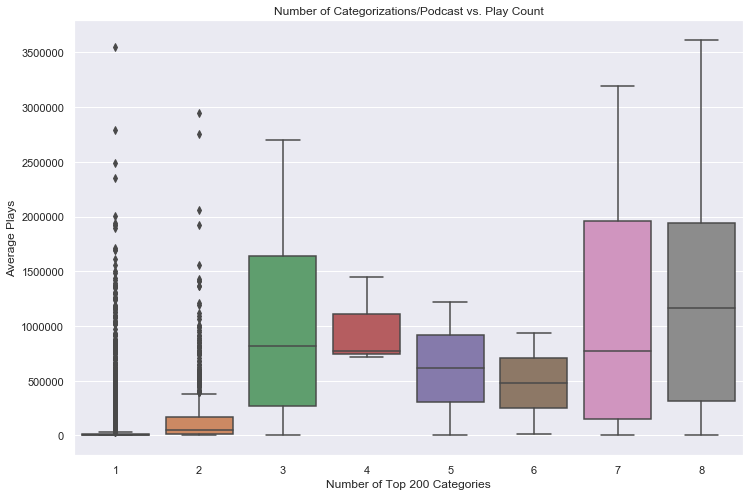

In [87]:
cat_count = df[outlier_mask].groupby(by='cat_count')['play_count'].mean()

fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='cat_count', y='play_count', data=df[outlier_mask])

plt.xlabel('Number of Top 200 Categories')
plt.ylabel('Average Plays')

plt.title('Number of Categorizations/Podcast vs. Play Count');

In [88]:
df.sample(8)[['title','cat_list']]

,title,cat_list
68,Encyclopedia Womannica,History
44,Rose Chat Podcast,Home & Garden
126,That's So Maven by The Healthy Maven,Alternative Health
114,The Wolf's Den,Business
106,Selected Shorts: Too Hot For Radio,Performing Arts
89,رادیو داستان | Radio Daastaan,Books
64,The SavingsAngel Show,How to
87,The ALLiN³ Podcast,Fitness


### One-Hot Encoding

In [89]:
df.cat_list.sample(5)

125      Alternative Health
118         Science Fiction
2                 Sexuality
164    Arts|Performing Arts
27          News Commentary
Name: cat_list, dtype: object

In [90]:
# Build dummy categories from full category list
dummies = df.cat_list.str.get_dummies()

In [91]:
# its a sparse matrix
dummies.sample(5)

,After Shows,Alternative Health,Animation & Manga,Arts,Automotive,Aviation,Books,Buddhism,Business,Business News,...,Sports News,Standup,Stories for Kids,TV & Film,TV Reviews,Tech News,Technology,True Crime,Video Games,Visual Arts
173,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# replace non-alpha in category name:

# Append to original dataframe
for col in dummies.columns:
    pattern = re.compile('[\W_]+')
    cat_name = re.sub(r'\W+', '_', col)
    cat_name = 'd_' + cat_name
    df[cat_name] = dummies[col]

In [93]:
df.sample()

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed_socials,ep_total,recent_eps,...,domain,twitter_log,page_rank_dec,rank,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,avg_ep_desc_len,chan_desc_len
73,The Jeselnik & Rosenthal Vanity Project,https://castbox.fm/channel/The-Jeselnik-%26-Rosenthal-Vanity-Project-id1407821,21,Comedy Central & Anthony Jeselnik Gregg Rosenthal,1,3999,129214,[https://art19.com/shows/the-jeselnik-rosenthal-vanity-project],49,"[[2019-10-04, 00:21:15, 0], [2019-10-02, 00:41:20, 2], [2019-09-27, 00:21:10, 2], [2019-09-25, 0...",...,art19.com,-inf,5.2,182311,10.4,0.1,217.2,387.0,216.6,244


## Social Channels

Podcasts have the option of listing their social channels. Let's create categoricals for those variables if they exist.

### Create Categorical Columns Representing Social Site Presence

In [94]:
# function to check for existence of a specific domain

def has_domain(row, social_domain):
#     print(row)
    ch_feed_socials = row
    for link in ch_feed_socials:
        pattern = '.*' + social_domain + '.*'
#         print(pattern, link)
#         print(re.match(pattern, link))
        if re.match(pattern, link):
            return 1
    return 0

In [95]:
social_domains = ['twitter', 'facebook', 'youtube', 'instagram']

for domain in social_domains:
    df[domain] = df['ch_feed_socials'].apply(has_domain,social_domain=domain)

In [96]:
df.sample(5)[social_domains]

,twitter,facebook,youtube,instagram
27,1,0,0,0
52,0,0,0,0
166,0,0,0,0
137,0,0,0,0
23,0,0,0,0


### Pull in Twitter Follower Counts

(for ones that have it)

In [97]:
# Get Twitter follower-count dictionary
with open('../social_metrics/twitter/channel_stats_by_name_oct7_9p.pickle', 'rb') as file:
    twitter_dict = pickle.load(file)
    
[twitter_dict[key] for key in list(twitter_dict.keys())[-3:]]

[{'title': 'Ask The Tech Guy (Video HD)',
  'chan_url': 'https://castbox.fm/channel/Ask-The-Tech-Guy-(Video-HD)-id2237855',
  'ch_feed-socials': ['https://twitter.com/TWiT',
   'https://www.facebook.com/TWiTNetwork',
   'https://www.instagram.com/twit.tv',
   'https://www.youtube.com/channel/UCCdBun8mTfRzbZYAE9nXLDQ',
   'https://twit.tv/shows/ask-the-tech-guy'],
  'screen_name': 'TWiT',
  'follower_count': 83273},
 {'title': 'WRITERS IN TECH',
  'chan_url': 'https://castbox.fm/channel/WRITERS-IN-TECH-id2154199',
  'ch_feed-socials': ['https://twitter.com/KeshYuval',
   'https://www.facebook.com/writingux',
   'https://www.instagram.com/uxwritinghub',
   'http://uxwritinghub.com/'],
  'screen_name': 'KeshYuval',
  'follower_count': 577},
 {'title': 'Ask The Tech Guy (MP3)',
  'chan_url': 'https://castbox.fm/channel/Ask-The-Tech-Guy-(MP3)-id2237730',
  'ch_feed-socials': ['https://twitter.com/TWiT',
   'https://www.facebook.com/TWiTNetwork',
   'https://www.instagram.com/twit.tv',
   'h

In [98]:
def pull_twitter_followers(row):
    title = row.title
    try:
        return twitter_dict[title]['follower_count']
    except:
        return 0

In [99]:
df['twitter_followers'] = df.apply(lambda row: pull_twitter_followers(row), axis=1)

In [100]:
# Quick look into twitter_followers vs. play_count
print(df.twitter_followers.describe())
print(df[['twitter_followers', 'play_count']].corr())

count       7543.0
mean       65359.5
std      1121478.3
min            0.0
25%            0.0
50%            0.0
75%            0.0
max     78705541.0
Name: twitter_followers, dtype: float64
                   twitter_followers  play_count
twitter_followers                1.0         0.1
play_count                       0.1         1.0


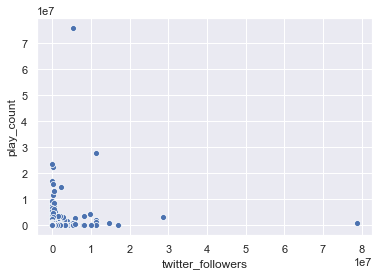

In [101]:
sns.scatterplot(x='twitter_followers',y='play_count', data=df)

In [102]:
df['twitter_sqrt'] = np.sqrt(df.twitter_followers)

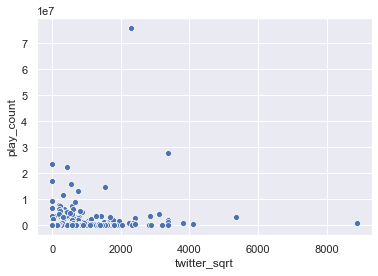

In [103]:
sns.scatterplot(x='twitter_sqrt',y='play_count', data=df)

## External Site Domain Rank

Do they have their own channel site or do they use a podcast syndication platform?

Some podcast have their own site. Some podcasts are listed on LibSyn, Anchor.fm, or another podcast hosting platform. I've extracted those sites.

*FUTURE DEV: At the moment, I'm not differentiating / identifying common podcast hosting platforms. I'm treating all "non-social" sites as the same. In the future the model should treat records with libsyn listings as their own categorical.*

### Identify Non-Social External Site, and Return/Append Domain Rank Information

In [112]:
df['external_site'] = df['ch_feed_socials'].apply(features.return_external_site_domain)
df['domain'] = df.external_site.apply(features.extract_domain)

In [113]:
df.sample(5)[['ch_feed_socials','external_site','domain']]

,ch_feed_socials,external_site,domain
45,"[https://twitter.com/heavyweight, https://www.facebook.com/heavyweightpodcast, https://gimletmed...",https://gimletmedia.com/show/heavyweight/,gimletmedia.com
157,[https://www.nielsenconsults.com],https://www.nielsenconsults.com,nielsenconsults.com
27,[https://www.emergencymedicalminute.com],https://www.emergencymedicalminute.com,emergencymedicalminute.com
8,"[https://twitter.com/stevegibson2000, https://twit.tv/shows/security-now]",https://twit.tv/shows/security-now,twit.tv
48,[https://www.fictionforadults.com/paladincyclepodcast],https://www.fictionforadults.com/paladincyclepodcast,fictionforadults.com


In [114]:
with open('../social_metrics/external_domains/external_domain_dicts.pickle','rb') as file:
    domain_dict = pickle.load(file)

In [115]:
sample_domains = [k for k in domain_dict.keys()][:5]
for s in sample_domains:
    print(s,domain_dict[s])

tablegroup.com {'page_rank_dict': 4.74, 'rank': '253465'}
learningleadershow.com {'page_rank_dict': 3.31, 'rank': '6895641'}
johnmaxwellteam.com {'page_rank_dict': 4.23, 'rank': '1566549'}
spreaker.com {'page_rank_dict': 6.76, 'rank': '1360'}
rework.fm {'page_rank_dict': 4.3, 'rank': '1458460'}


In [116]:
def get_dec_rank(domain):
    '''
    
    Page rank. Out of 10, 10 is best.
    
    '''
    
    
    domain = domain.lower()
    try:
        return float(domain_dict[domain]['page_rank_dict'])
    except:
        return 0.0 # lowest decimal page rank
        
def get_rank(domain):
    '''
    for this metric lower means better
    
    '''
    
    domain = domain.lower()
    try:
        return int(domain_dict[domain]['rank'])
    except:
        return 153096046 # the page rank for my (unlaunched) personal site. Bad

In [117]:
df['page_rank_dec'] = df.domain.apply(get_dec_rank)
df['rank'] = df.domain.apply(get_rank)

In [118]:

for key,val in df.dtypes.items():
    print(val,'----',key )

object ---- title
object ---- chan_url
int64 ---- num_comments
object ---- author
int64 ---- isExplicit
int64 ---- sub_count
int64 ---- play_count
object ---- ch_feed_socials
int64 ---- ep_total
object ---- recent_eps
object ---- hover_text_concat
object ---- chan_desc
object ---- cover_img_url
object ---- first_release
object ---- scraped_category
object ---- cat_list
int64 ---- cat_count
int64 ---- d_After_Shows
int64 ---- d_Alternative_Health
int64 ---- d_Animation_Manga
int64 ---- d_Arts
int64 ---- d_Automotive
int64 ---- d_Aviation
int64 ---- d_Books
int64 ---- d_Buddhism
int64 ---- d_Business
int64 ---- d_Business_News
int64 ---- d_Careers
int64 ---- d_Christianity
int64 ---- d_Comedy
int64 ---- d_Comedy_Fiction
int64 ---- d_Comedy_Interviews
int64 ---- d_Courses
int64 ---- d_Crafts
int64 ---- d_Daily_News
int64 ---- d_Design
int64 ---- d_Documentary
int64 ---- d_Drama
int64 ---- d_Education
int64 ---- d_Education_for_Kids
int64 ---- d_Entertainment_News
int64 ---- d_Entrepreneur

In [119]:
df[['title','domain','page_rank_dec','rank']].sample(5)

,title,domain,page_rank_dec,rank
55,Fit and Free,katiemillerfitness.com,1.6,53928078
125,The Fizzle Show,fizzleshow.co,3.1,8203302
105,New Layer,shape.co,1.9,33002416
33,GroupChat - A PopCulture.com Reality TV Podcast,popculture.com,5.2,184943
56,"Screw It, We're Just Gonna Talk About Comics",wearecampfire.media,3.7,3925575


## Add Episode Time Series Features

In [120]:
df = features.sanitize(df)

In [121]:
reload(features)

<module 'features' from '/Users/tk/Google Drive (thomaskavanagh.dev@gmail.com)/GitHub/regression-podcast-popularity/notebooks/features.py'>

In [122]:
df.head()

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed_socials,ep_total,recent_eps,...,domain,twitter_log,page_rank_dec,rank,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,avg_ep_desc_len,chan_desc_len
0,At The Table with Patrick Lencioni,https://castbox.fm/channel/At-The-Table-with-Patrick-Lencioni-id2219654,0,Patrick Lencioni,0,119,1686,[https://www.tablegroup.com],13,"[[2019-10-02, 00:34:32, 0], [2019-09-25, 00:27:06, 0], [2019-09-23, 00:33:47, 0], [2019-09-16, 0...",...,tablegroup.com,-inf,4.7,253465,6.3,0.2,218.0,83.0,283.2,497
1,The Learning Leader Show With Ryan Hawk,https://castbox.fm/channel/The-Learning-Leader-Show-With-Ryan-Hawk-id7505,3,Ryan Hawk,1,1283,31249,[http://LearningLeaderShow.com],331,"[[2019-09-29, 01:03:30, 2], [2019-09-25, 01:14:53, 1], [2019-09-22, 00:56:06, 0], [2019-09-15, 0...",...,LearningLeaderShow.com,-inf,3.3,6895641,6.2,0.2,217.3,1634.0,3867.3,269
2,Transformational Leader Podcast,https://castbox.fm/channel/Transformational-Leader-Podcast-id2045469,2,Paul Martinelli and the John Maxwell Team,0,301,2444,[https://johnmaxwellteam.com/],32,"[[2019-10-02, 00:42:30, 0], [2019-09-25, 00:38:06, 0], [2019-09-18, 00:38:43, 0], [2019-09-11, 0...",...,johnmaxwellteam.com,-inf,4.2,1566549,7.0,0.2,218.7,209.0,2036.6,202
3,"Switch, Pivot or Quit",https://castbox.fm/channel/Switch%2C-Pivot-or-Quit-id1471235,3,Mayzie Media,0,684,14210,[https://www.spreaker.com/show/switch-pivot-or-quit-career-switch-perso],258,"[[2019-10-02, 01:01:34, 0], [2019-09-25, 00:45:31, 0], [2019-09-18, 01:10:46, 0], [2019-09-11, 0...",...,spreaker.com,-inf,6.8,1360,7.0,0.3,218.5,995.0,468.7,914
4,Rework,https://castbox.fm/channel/Rework-id980288,0,Basecamp,0,1530,32204,[https://rework.fm],84,"[[2019-10-01, 01:07:30, 0], [2019-09-24, 00:32:11, 0], [2019-09-17, 00:26:59, 0], [2019-09-10, 0...",...,rework.fm,-inf,4.3,1458460,6.2,0.1,217.2,797.0,383.6,175


In [123]:
# More 
df = features.build_features(df, feature_set='episode')

building episode time series features


In [124]:
df.columns

Index(['title', 'chan_url', 'num_comments', 'author', 'isExplicit',
       'sub_count', 'play_count', 'ch_feed_socials', 'ep_total', 'recent_eps',
       ...
       'domain', 'twitter_log', 'page_rank_dec', 'rank', 'recent_ep_spacing',
       'lifetime_ep_freq', 'avg_ep_len', 'chan_age', 'avg_ep_desc_len',
       'chan_desc_len'],
      dtype='object', length=121)

In [125]:
df.sample(10)[['play_count','rank','page_rank_dec','twitter_followers','recent_ep_spacing','lifetime_ep_freq','avg_ep_len','chan_age']]

,play_count,rank,page_rank_dec,twitter_followers,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age
186,68350,3304104,3.9,0,7.0,0.2,217.2,2535.0
136,37442,1846533,4.1,8196,1.7,0.3,219.3,204.0
100,3143,1359,6.8,0,4.7,0.2,218.4,885.0
141,0,10786047,2.9,0,28.0,0.1,217.4,28.0
40,1103,6966265,3.3,0,15.4,0.1,216.2,1373.0
77,104111,63,8.4,0,18.8,0.1,218.5,436.0
196,1209,177336,5.5,0,8.3,0.1,220.7,1782.0
47,59,24813227,2.1,0,58.3,0.0,217.2,350.0
131,2125,1006,6.9,0,9.8,0.2,216.0,106.0
72,258,404174,4.6,0,42.6,0.0,218.4,489.0


## Distribution of Target Variable
### Target Variable = `play_count`

In [126]:
df.play_count.describe()

count       7543.0
mean      125331.4
std      1163253.6
min            0.0
25%          313.0
50%         3490.0
75%        26862.0
max     76019418.0
Name: play_count, dtype: float64

The distribution of play counts is heavily left-skewed, with ~75% of podcasts having less than 120,000 plays. Let's zoom in on the bottom 75%.

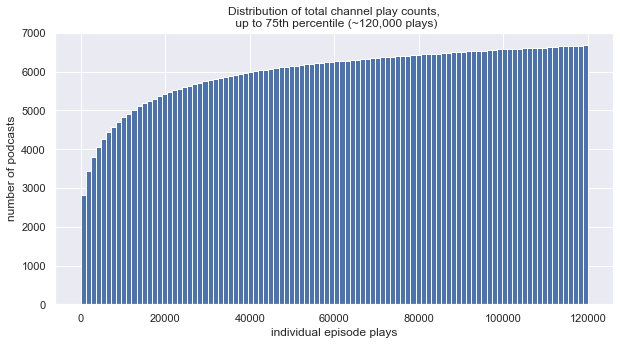

In [128]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Distribution of total channel play counts,\n up to 75th percentile (~120,000 plays)')
plt.xlabel('individual episode plays')
plt.ylabel('number of podcasts')
plt.hist(df.play_count, bins=100, log=False,cumulative=True, range=[0,120000]); 

Let's do the same for subscribers.

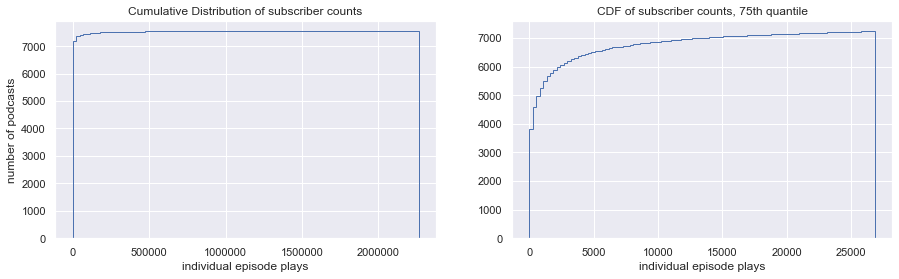

In [129]:
plt.subplots(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.title('Cumulative Distribution of subscriber counts')
plt.xlabel('individual episode plays')
plt.ylabel('number of podcasts')
plt.hist(df.sub_count, bins=100, log=False,cumulative=True, histtype='step'); 

# now just plot for the bottom 75%
plt.subplot(1, 2, 2)
# get 75th percentile value
sub_75_q = df.play_count.quantile(0.75)
plt.title('CDF of subscriber counts, 75th quantile')
plt.xlabel('individual episode plays')
plt.hist(df.sub_count, bins=100, log=False,cumulative=True, range=[0,sub_75_q],  histtype='step'); 



Play count and subscriber count have very similar CDFs. And naturally they are very strongly correlated. This metric should probably not be included in our model, as it doens't provide much actionable insight to know that subscribers have an effect on play count.

In [130]:
np.corrcoef(x = df.play_count, y = df.sub_count)

array([[1.        , 0.88681667],
       [0.88681667, 1.        ]])

## Text Based Analysis

In [131]:
def calc_avg_desc_len(hover_text):
    
    try:
        ep_desc_list = hover_text.split('|')
#     print(ep_desc_list)
        return np.mean([len(d) for d in ep_desc_list])
    except:
        return 0

In [132]:
df['avg_ep_desc_len'] = df.hover_text_concat.apply(calc_avg_desc_len)
df['chan_desc_len'] = df.chan_desc.apply(lambda x: len(x))

# Models

In [163]:
# Assess the numerical columns we have to work with:
numerical_columns = []
for f, var_type in df.dtypes.items():
    if var_type == 'int64' or var_type == 'float64':
        if 'd_' not in f:
            numerical_columns.append(f)

print('numerical columns:\n', numerical_columns)

numerical columns:
 ['num_comments', 'isExplicit', 'sub_count', 'play_count', 'ep_total', 'cat_count', 'twitter', 'facebook', 'youtube', 'instagram', 'twitter_followers', 'twitter_sqrt', 'twitter_log', 'page_rank_dec', 'rank', 'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len', 'chan_age', 'avg_ep_desc_len', 'chan_desc_len', 'twitter_exp']


In [182]:
# Remove the columns inappropriate for this regression:
numericals_reg = []

for el in numerical_columns:
    
    disqualify = ['num_comments', 'play_count','twitter_exp','twitter_log','sub_count','cat_count']
    
    if el not in disqualify:
        numericals_reg.append(el)

In [183]:
# Assess the categorical columns we have to work with:
categorical_columns = []
for f, var_type in df.dtypes.items():
    if var_type == 'int64' or var_type == 'float64':
        if 'd_' in f:
            categorical_columns.append(f)

print('categorical columns:\n', categorical_columns)

categorical columns:
 ['d_After_Shows', 'd_Alternative_Health', 'd_Animation_Manga', 'd_Arts', 'd_Automotive', 'd_Aviation', 'd_Books', 'd_Buddhism', 'd_Business', 'd_Business_News', 'd_Careers', 'd_Christianity', 'd_Comedy', 'd_Comedy_Fiction', 'd_Comedy_Interviews', 'd_Courses', 'd_Crafts', 'd_Daily_News', 'd_Design', 'd_Documentary', 'd_Drama', 'd_Education', 'd_Education_for_Kids', 'd_Entertainment_News', 'd_Entrepreneurship', 'd_Fantasy_Sports', 'd_Fashion_Beauty', 'd_Fiction', 'd_Film_History', 'd_Film_Reviews', 'd_Fitness', 'd_Food', 'd_Games', 'd_Games_Hobbies', 'd_Government', 'd_Government_Organizations', 'd_Health', 'd_Health_Fitness', 'd_Hinduism', 'd_History', 'd_Hobbies', 'd_Home_Garden', 'd_How_to', 'd_Improv', 'd_Investing', 'd_Kids_Family', 'd_Language_Learning', 'd_Leisure', 'd_Management_', 'd_Marketing', 'd_Medicine', 'd_Mental_Health', 'd_Music', 'd_Music_Commentary', 'd_Music_History', 'd_Music_Interviews', 'd_News', 'd_News_Politics', 'd_News_Commentary', 'd_Non_

In [184]:
df = df.dropna()

In [185]:
df.describe()

//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,num_comments,isExplicit,sub_count,play_count,ep_total,cat_count,d_After_Shows,d_Alternative_Health,d_Animation_Manga,d_Arts,...,twitter_log,page_rank_dec,rank,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,avg_ep_desc_len,chan_desc_len,twitter_exp
count,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,...,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0,7543.0
mean,17.3,0.2,6544.4,125331.4,137.9,1.2,0.0,0.0,0.0,0.0,...,-inf,4.4,19447366.3,15.8,0.2,217.7,938.4,764.2,389.0,inf
std,267.8,0.4,45584.2,1163253.6,277.0,0.9,0.0,0.2,0.1,0.2,...,nan,2.1,50692376.9,29.8,1.1,1.4,1190.3,1551.5,318.0,nan
min,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,-inf,0.0,2.0,0.0,0.0,211.7,0.0,1.0,0.0,1.0
25%,0.0,0.0,35.0,313.0,19.0,1.0,0.0,0.0,0.0,0.0,...,-inf,3.2,17124.0,6.2,0.1,216.8,200.0,269.1,186.0,1.0
50%,0.0,0.0,259.0,3490.0,61.0,1.0,0.0,0.0,0.0,0.0,...,nan,4.5,544985.0,7.7,0.1,217.7,618.0,463.6,322.0,1.0
75%,4.0,0.0,1604.5,26862.0,158.5,1.0,0.0,0.0,0.0,0.0,...,-inf,6.0,7650791.0,15.6,0.2,218.6,1318.5,865.1,506.0,1.0
max,21769.0,1.0,2262375.0,76019418.0,4998.0,8.0,1.0,1.0,1.0,1.0,...,18.2,10.0,445371504.0,1249.5,61.0,223.3,18176.0,76571.4,9835.0,inf


In [186]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, cross_val_predict

In [187]:
def unscaled_OLS_model(data, x_cols, y_col='play_count', cv=5, test_size=0.2, val_size=0.2, verbose_=True):
    '''
    
    Take a dataframe, and a list of X features, a target y.
    Perform linear regression, and cross validation.
    
    '''
    
    print(f'Unscaled OLS Model with test_size {test_size} and val_size {val_size}')
    
    X, y = data[x_cols], data[y_col]
    
    # training split
    X, X_test, y, y_test = train_test_split(X, y, test_size=test_size)
    
    # validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)
    
    cv_model = LinearRegression()
    cv_results = cross_val_score(cv_model, X, y, cv=cv, scoring='r2')
    print('cross validation results with mean: ',np.mean(cv_results))
    print(cv_results)
    
    # Train an additional time to get a sample set of coefficients.
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(f'Linear Regression val R^2: {model.score(X_val, y_val):.3f}')

    
    c = zip(x_cols, model.coef_)

    if verbose_ == True:
        for z in c:
            print(z)
            
    print('\n')
    print('\n')
    return model

In [188]:
def scaled_OLS_model(data, x_cols, y_col='play_count', cv=5, test_size=0.2, val_size=0.2, verbose_=True):
    '''
    
    Take a dataframe, and a list of X features, a target y.
    Perform linear regression, and cross validation.
    
    '''
    
    print(f'Scaled OLS Model with test_size {test_size} and val_size {val_size}')
    
    X, y = data[x_cols], data[y_col]
    
    # training split
    X, X_test, y, y_test = train_test_split(X, y, test_size=test_size)
    
    # validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)
    
    model = LinearRegression()
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)
    
    cv_model = LinearRegression()
    cv_results = cross_val_score(cv_model, X, y, cv=cv, scoring='r2')
    print('cross validation results with mean: ',np.mean(cv_results))
    print(cv_results)
    
    model = LinearRegression()    
    model.fit(X_train_scaled, y_train)
    print(f'Linear Regression val R^2: {model.score(X_val_scaled, y_val):.3f}')
    print('\n')
    
    c = zip(x_cols, model.coef_)

    if verbose_ == True:
        for z in c:
            print(z)
    
    print('\n')
    print('\n')
    return model

In [189]:
def lassoCV_OLS_model(data, x_cols, y_col='play_count',cv=5, test_size=0.2, val_size=0.2, verbose_=True):
    '''
    
    Take a dataframe, and a list of X features, a target y.
    Perform linear regression, and cross validation.
    
    '''
    
    print(f'Scaled LassoCV Model with test_size {test_size} and val_size {val_size}')
    
    X, y = data[x_cols], data[y_col]
    
    # training split
    X, X_test, y, y_test = train_test_split(X, y, test_size=test_size)
    
    # validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)
    
    model = LinearRegression()
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)
    
    alpha_vec = 10**np.linspace(3,6,2000)
    
    lasso_model = LassoCV(alphas=alpha_vec, cv=cv)
    
    lasso_model.fit(X_train_scaled, y_train)
    
    print(f'Linear Regression val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')
    print('\n')
    best_alpha = lasso_model.alpha_
    print(f'best alpha is {best_alpha}')
    
    c = zip(x_cols, lasso_model.coef_)

    if verbose_ == True:
        for z in c:
            print(z)
    
    print('\n')
    print('\n')
    return model

## Testing simple linear models:

### Minimal Features - No Categoricals

In [191]:
minimal_features = numericals_reg

unscaled_OLS_model(df[outlier_mask], x_cols=numericals_reg)
scaled_OLS_model(df[outlier_mask], x_cols=numericals_reg)
lassoCV_OLS_model(df[outlier_mask], x_cols=numericals_reg)
;

Unscaled OLS Model with test_size 0.2 and val_size 0.2
cross validation results with mean:  0.32188243498995517
[0.29645551 0.30858501 0.34676416 0.35864282 0.29896467]
Linear Regression val R^2: 0.265
('isExplicit', 12595.273691967208)
('ep_total', 122.11009787440811)
('twitter', 66481.33541948136)
('facebook', 280756.36178317317)
('youtube', 151758.69307167944)
('instagram', -48279.172357428804)
('twitter_followers', -0.035350703304166155)
('twitter_sqrt', 363.52412334636523)
('page_rank_dec', 2899.819703227402)
('rank', -5.252997385030695e-05)
('recent_ep_spacing', -39.031728440898284)
('lifetime_ep_freq', -1498.8639386059006)
('avg_ep_len', 1045.8506073213507)
('chan_age', -6.062931895068105)
('avg_ep_desc_len', -0.2861668494981273)
('chan_desc_len', -2.244897405031898)




Scaled OLS Model with test_size 0.2 and val_size 0.2
cross validation results with mean:  0.3042676568468129
[0.37374289 0.32941644 0.24421179 0.28906062 0.28490654]
Linear Regression val R^2: 0.365


('isExplic

''

Not great at all. The model is overly punishing of Twitter Follower count. Perhaps that feature needs to be transformed before use in the model.

In [75]:
def scaled_poly_model(data, x_cols, y_col='play_count', test_size=0.2, val_size=0.2, random_state=4444):
    '''
    
    Take a dataframe, and a list of X features, a target y.
    Perform linear regression, and cross validation.
    
    '''
    
    X, y = data[x_cols], data[y_col]
    
    # training split
    X, X_test, y, y_test = train_test_split(X, y, test_size=test_size)
    
    # validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)
    
    model = LinearRegression()
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)
    
    model.fit(X_train, y_train)
    print(f'Linear Regression val R^2: {model.score(X_val, y_val):.3f}')
    
    return model

In [ ]:
X_non_test, X_test, y_non_test, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_non_test, y_non_test, test_size=0.2,random_state=42)

In [ ]:
simple_lr = LinearRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Ridge model
ridge_reg = Ridge(alpha = 10000)

In [ ]:
#validate

simple_lr.fit(X_train, y_train)
print(f'Linear Regression val R^2: {simple_lr.score(X_val, y_val):.3f}')

ridge_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {ridge_reg.score(X_val_scaled, y_val):.3f}')

In [ ]:
for z in zip(reg_cols, simple_lr.coef_):
    print(z)

In [ ]:
for z in zip(reg_cols, ridge_reg.coef_):
    print(z)

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [ ]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

In [ ]:
for z in zip(poly.get_feature_names(), lm_poly.coef_):
    print(z)

In [ ]:
minimal_features = (
    ['num_comments', 'isExplicit', 'sub_count', 'play_count', 'ep_total',
     'cat_count', 'd_After_Shows', 'd_Alternative_Health', 'd_Animation_Manga',
     'd_Arts', 'd_Automotive', 'd_Aviation', 'd_Books', 'd_Buddhism', 'd_Business',
     'd_Business_News', 'd_Careers', 'd_Christianity', 'd_Comedy', 'd_Comedy_Fiction',
     'd_Comedy_Interviews', 'd_Courses', 'd_Crafts', 'd_Daily_News', 'd_Design',
     'd_Documentary', 'd_Drama', 'd_Education', 'd_Education_for_Kids', 'd_Entertainment_News',
     'd_Entrepreneurship', 'd_Fantasy_Sports', 'd_Fashion_Beauty', 'd_Fiction', 'd_Film_History',
     'd_Film_Reviews', 'd_Fitness', 'd_Food', 'd_Games', 'd_Games_Hobbies', 'd_Government',
     'd_Government_Organizations', 'd_Health', 'd_Health_Fitness', 'd_Hinduism', 'd_History', 'd_Hobbies', 'd_Home_Garden', 'd_How_to', 'd_Improv', 'd_Investing', 'd_Kids_Family', 'd_Language_Learning', 'd_Leisure', 'd_Management_', 'd_Marketing', 'd_Medicine', 'd_Mental_Health', 'd_Music', 'd_Music_Commentary', 'd_Music_History', 'd_Music_Interviews', 'd_News', 'd_News_Politics', 'd_News_Commentary', 'd_Non_profit', 'd_Nutrition', 'd_Parenting', 'd_Performing_Arts', 'd_Personal_Journals', 'd_Pets_Animals', 'd_Politics', 'd_Relationships', 'd_Religion_Spirituality', 'd_Science', 'd_Science_Medicine', 'd_Science_Fiction', 'd_Self_Improvement', 'd_Sexuality', 'd_Social_Sciences', 'd_Society_Culture', 'd_Sports', 'd_Sports_Recreation', 'd_Sports_News', 'd_Standup', 'd_Stories_for_Kids', 'd_TV_Film', 'd_TV_Reviews', 'd_Tech_News', 'd_Technology', 'd_True_Crime', 'd_Video_Games', 'd_Visual_Arts', 'twitter', 'facebook', 'youtube', 'instagram', 'twitter_followers', 'page_rank_dec', 'rank', 'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len', 'chan_age', 'avg_ep_desc_len', 'chan_desc_len'])

scaled_linear_model(data, x_cols=['','','',''])

In [ ]:
# predictors
X = reg_df[reg_and_cat_cols]

# target
y = reg_df.play_count

In [ ]:
X_non_test, X_test, y_non_test, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_non_test, y_non_test, test_size=0.2,random_state=42)

In [ ]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=10000)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=3) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [ ]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 3 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

In [ ]:
for z in zip(reg_cols, lm.coef_):
    print(z)

In [ ]:
for z in zip(reg_cols, lm_reg.coef_):
    print(z)

In [ ]:
from sklearn.model_selection import KFold

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [ ]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=100)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

In [ ]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))